In [64]:

#Imports
import os
import pandas as pd
import random
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

In [65]:
# Enable GPU acceleration
def configure_gpu():
    try:
        # List physical devices
        physical_devices = tf.config.list_physical_devices('GPU')
        
        if physical_devices:
            # Print available GPUs
            print(f"Found {len(physical_devices)} GPU(s):")
            for device in physical_devices:
                print(f" - {device}")
                
            # Important: Set memory growth BEFORE setting any other GPU configurations
            try:
                for device in physical_devices:
                    tf.config.experimental.set_memory_growth(device, True)
                print("Memory growth enabled on all GPUs")
            except RuntimeError as e:
                print(f"Warning: {e}")
                
            # Enable mixed precision after memory growth configuration
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("Enabled mixed precision training")
        else:
            print("No GPU devices found")
            
    except Exception as e:
        print(f"Error configuring GPU: {e}")


configure_gpu()

No GPU devices found


In [66]:
# Paths for the dataset
TRAIN_PATH = 'D:/Download/JDownloader/MSCOCO/images/train2017'
VAL_PATH = 'D:/Download/JDownloader/MSCOCO/images/val2017'
ANNOTATIONS_PATH = 'D:/Download/JDownloader/MSCOCO/annotations'
WORKING_DIR = 'D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/code/working'
VAL_MODEL_IMG = 'D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/code/val_model_img'

In [67]:
# Filtered categories
FILTERED_CATEGORIES = ['person', 'cat', 'dog']

# Load COCO annotations
annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_train2017.json')
coco = COCO(annotations_file)

# Get category IDs for the selected categories
category_ids = coco.getCatIds(catNms=FILTERED_CATEGORIES)

# Collect up to 1000 annotations per category
filtered_data = []
for category_id in category_ids:
    ann_ids = coco.getAnnIds(catIds=[category_id])
    anns = coco.loadAnns(ann_ids)
    selected_anns = random.sample(anns, min(1000, len(anns)))
    for ann in selected_anns:
        image_info = coco.loadImgs(ann['image_id'])[0]
        filtered_data.append({
            "image_id": ann['image_id'],
            "image": image_info['file_name'],
            "category_id": ann['category_id']
        })

# Save filtered data to CSV
filtered_csv_path = os.path.join(WORKING_DIR, 'filtered_coco.csv')
filtered_df = pd.DataFrame(filtered_data)
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered dataset saved to {os.path.abspath(filtered_csv_path)}")

loading annotations into memory...
Done (t=8.41s)
creating index...
index created!
Filtered dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\code\working\filtered_coco.csv


In [68]:
# Split the filtered dataset
# Load the filtered CSV
data = pd.read_csv(filtered_csv_path)

# Display record count per category_id
category_counts = data['category_id'].value_counts()
print("Record count per category_id:")
print(category_counts)
print("")

# Split into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Display record count per category_id train and test
category_train_counts = train_data['category_id'].value_counts()
print("Train - Record count per category_id:")
print(category_train_counts)
print("")

category_test_counts = test_data['category_id'].value_counts()
print("Test - Record count per category_id:")
print(category_test_counts)
print("")

# Save the split datasets
train_csv_path = os.path.join(WORKING_DIR, 'train_data.csv')
test_csv_path = os.path.join(WORKING_DIR, 'test_data.csv')

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

print(f"Training dataset saved to {os.path.abspath(train_csv_path)}")
print(f"Testing dataset saved to {os.path.abspath(test_csv_path)}")



Record count per category_id:
category_id
1     1000
17    1000
18    1000
Name: count, dtype: int64

Train - Record count per category_id:
category_id
18    814
17    803
1     783
Name: count, dtype: int64

Test - Record count per category_id:
category_id
1     217
17    197
18    186
Name: count, dtype: int64

Training dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\code\working\train_data.csv
Testing dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\code\working\test_data.csv


In [69]:
# Load train and test data
# train_data = pd.read_csv(train_csv_path)
# test_data = pd.read_csv(test_csv_path)

In [70]:
# Preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image for MobileNetV2."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load images and labels
def load_data(data, path_prefix, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in data.iterrows():
        image_path = os.path.join(path_prefix, row['image'])
        images.append(preprocess_image(image_path, target_size))
        labels.append(row['category_id'])
    return np.array(images), np.array(labels)

X_train, y_train = load_data(train_data, TRAIN_PATH)
X_test, y_test = load_data(test_data, TRAIN_PATH)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))


In [71]:
# Build the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add classification head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)  # 3 classes: person, cat, dog
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 8,028,675 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [72]:
# Train the model
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=10,  # Adjust epochs based on performance
    batch_size=32,
    verbose=1
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.6003 - loss: 5.9962 - val_accuracy: 0.8000 - val_loss: 0.5425
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 331ms/step - accuracy: 0.9117 - loss: 0.2626 - val_accuracy: 0.7617 - val_loss: 0.5781
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 350ms/step - accuracy: 0.9790 - loss: 0.0992 - val_accuracy: 0.7833 - val_loss: 0.6835
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.9905 - loss: 0.0570 - val_accuracy: 0.7850 - val_loss: 0.6937
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 338ms/step - accuracy: 0.9938 - loss: 0.0371 - val_accuracy: 0.7883 - val_loss: 0.7025
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.9889 - loss: 0.0427 - val_accuracy: 0.7367 - val_loss: 1.0120
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 361ms/step - accuracy: 0.9925 - loss: 0.0482 - val_accuracy: 0.7867 - val_loss: 0.6927
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 362ms/step - accuracy: 0.9927 - loss: 0.0400 - val_accu

In [73]:
# Save the trained model
model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
model.save(model_path)

print(f"Trained model saved at {model_path}")

Trained model saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/code/working\mobilenet_v2_coco.keras


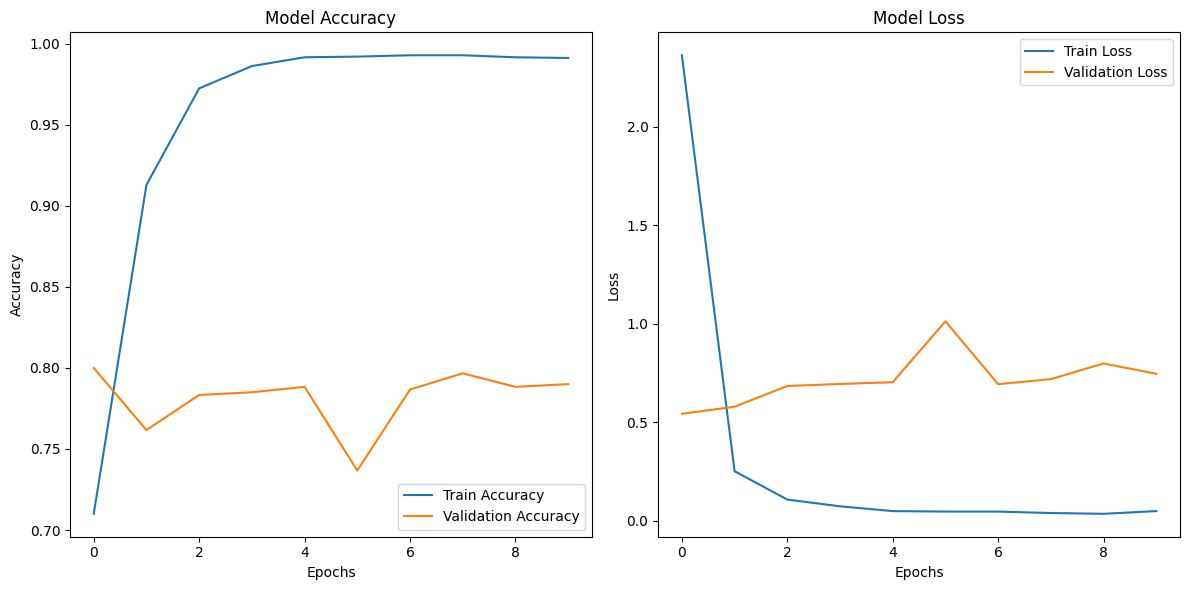

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step


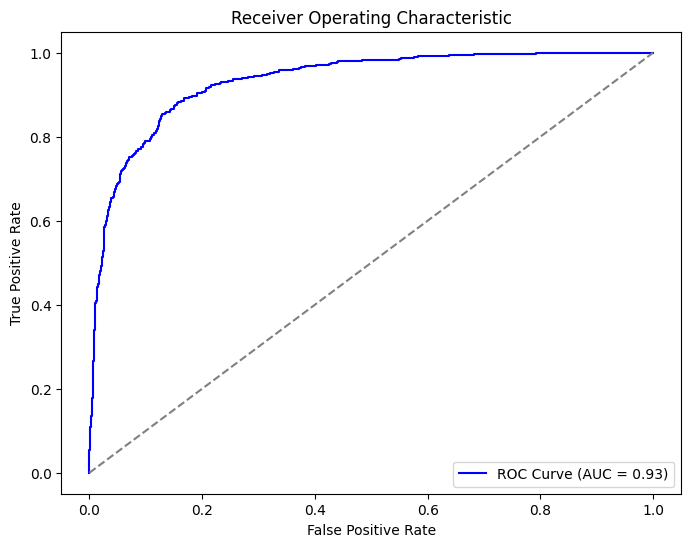

In [74]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve
y_test_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test_encoded.ravel(), y_test_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [75]:
# # Load the saved model
# model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
# loaded_model = tf.keras.models.load_model(model_path)
# print(f"Model loaded from {model_path}")

# # Load COCO validation annotations
# val_annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_val2017.json')
# coco_val = COCO(val_annotations_file)

# # Retrieve one image for each requested category
# validation_images = {}
# for category_name in FILTERED_CATEGORIES:
#     cat_id = coco_val.getCatIds(catNms=[category_name])[0]
#     img_ids = coco_val.getImgIds(catIds=[cat_id])
#     if img_ids:
#         img_id = img_ids[0]  # Get the first image ID for simplicity
#         img_info = coco_val.loadImgs(img_id)[0]
#         validation_images[category_name] = os.path.join(VAL_PATH, img_info['file_name'])
# # Function to predict category for an image, now measuring inference time
# def predict_category_with_time(image_path, model, target_size=(224, 224)):
#     image = preprocess_image(image_path, target_size)
#     image = np.expand_dims(image, axis=0)  # Add batch dimension

#     # Measure inference time
#     start_time = time.time()
#     predictions = model.predict(image)
#     inference_time = time.time() - start_time

#     predicted_class = np.argmax(predictions)
#     confidence = predictions[0][predicted_class]
#     return predicted_class, confidence, inference_time

# # Function to display image with prediction results and inference time
# def display_image_with_prediction(image_path, true_category, predicted_label, confidence, inference_time):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display
#     plt.figure(figsize=(6, 6))
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title(f"True: {true_category}\n"
#               f"Predicted: {predicted_label} ({confidence*100:.2f}%)\n"
#               f"Inference Time: {inference_time*1000:.2f} ms")
#     plt.show()

# # Perform predictions and display images with inference time
# for category, image_path in validation_images.items():
#     predicted_class, confidence, inference_time = predict_category_with_time(image_path, loaded_model)
#     predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
#     # Display image with prediction results and inference time
#     display_image_with_prediction(image_path, category, predicted_label, confidence, inference_time)
# # Load the saved model
# model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
# loaded_model = tf.keras.models.load_model(model_path)
# print(f"Model loaded from {model_path}")

# # Load COCO validation annotations
# val_annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_val2017.json')
# coco_val = COCO(val_annotations_file)

Model loaded from D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/code/working\mobilenet_v2_coco.keras
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


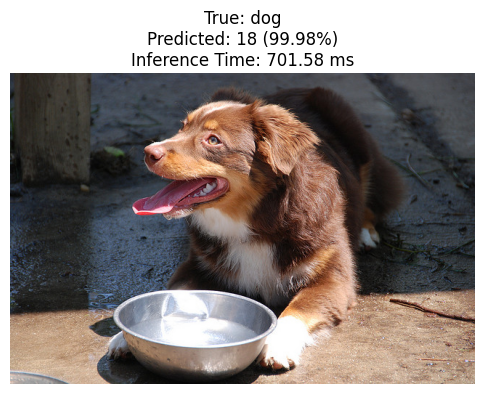

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


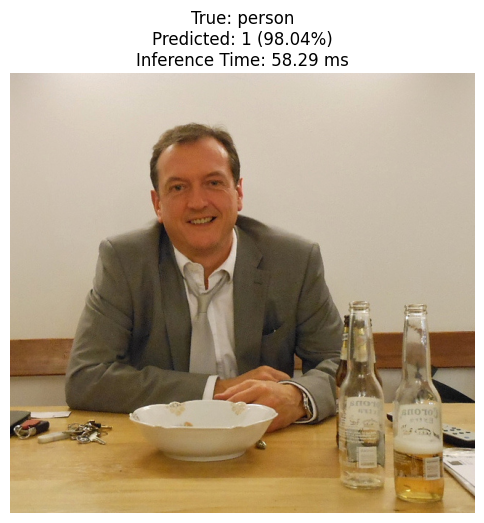

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


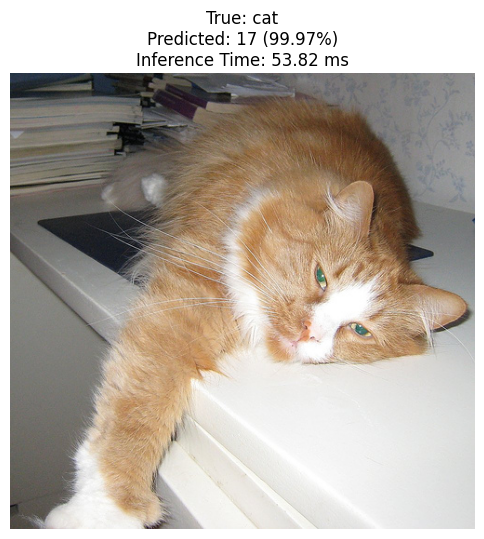

In [78]:
# Load the saved model
model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
loaded_model = tf.keras.models.load_model(model_path)
print(f"Model loaded from {model_path}")

# Load COCO validation annotations
val_annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_val2017.json')
coco_val = COCO(val_annotations_file)

image_filenames = ['000000205834.jpg', '000000050811.jpg', '000000058111.jpg']

# Create full paths for the images
validation_images = {filename: os.path.join(VAL_MODEL_IMG, filename) for filename in image_filenames}

# Function to predict category for an image, now measuring inference time
def predict_category_with_time(image_path, model, target_size=(224, 224)):
    image = preprocess_image(image_path, target_size)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Measure inference time
    start_time = time.time()
    predictions = model.predict(image)
    inference_time = time.time() - start_time

    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]
    return predicted_class, confidence, inference_time

# Function to display image with prediction results and inference time
def display_image_with_prediction(image_path, predicted_label, confidence, inference_time):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display
    true_category = coco_val.cats[predicted_label]['name']  
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_category}\n"
              f"Predicted: {predicted_label} ({confidence*100:.2f}%)\n"
              f"Inference Time: {inference_time*1000:.2f} ms")
    plt.show()

# Perform predictions and display images with inference time
for filename, image_path in validation_images.items():
    predicted_class, confidence, inference_time = predict_category_with_time(image_path, loaded_model)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    # Display image with prediction results and inference time
    display_image_with_prediction(image_path, predicted_label, confidence, inference_time)
